### Introduction

The data that we have available for this notebook is 1 day price data of two stocks i.e. Instrument A and Instrument B. 

In this notebook, we will perform several studies on these stocks and work towards a trading model.

We divide the notebook in steps: 

1 - Data Preprocessing (which includes inspection, filtering, cleaning and sorting)

2 - Analyses (including correlation and cointegration between the two stocks)

3 - Trading model

In this notebook we will use a few external libraries. We will import those libraries when appropriate.

### 1 - Preprocessing

We analyse the datasets and describe our findings. When we encounter issues, we address them clearly and explain how we approach them.

#### Describe the data

In [1]:
# Import the necessary libraries to read and manipulate the data
import pandas as pd
import numpy as np

In [2]:
# Read the csv files into pandas dataframe
# Parse the time column as a date (datetime object)
date_cols = ['Time']
instrument_A = pd.read_csv("dataset_instrument_A.csv", parse_dates = date_cols)
instrument_B = pd.read_csv("dataset_instrument_B.csv", parse_dates = date_cols)

In [3]:
# Print the interesting properties of dataset instrument_A 
print(instrument_A.info())
print(instrument_A.describe())
print(instrument_A.head())

# Here are our findings connected to instrument A:
# The dataset contains 6 columns, but the most important ones are Time and Price, since the information contained in the other columns can be extrapolated from the Time column as well
# This dataset contains price information connected to a stock over the course of one working day, from 9 AM until 5 PM
# We find that the average price of the stock is 43.209417, and throughout the given day it fluctuates between 38.080000 and 48.990000
# We also find that the data is not sorted chronologically, hence we decide to sort it based on the Time column
# This makes perfect sense, since we want to study the possibility of using this stock in a trading strategy
# We sort the data using the following commands
instrument_A.sort_values('Time', ascending=True, inplace=True) # inplace=True ensures that the dataframe itself is modified
# We also reset the indiex so that the index now also corresponds to chrological order for the data points
instrument_A.reset_index(drop=True, inplace=True)
print(instrument_A.head())
# And as we can see, the data is now sorted chronologically, which makes it easier to interpret and analyse the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96465 entries, 0 to 96464
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Hour         96465 non-null  int64         
 1   Minute       96465 non-null  int64         
 2   Second       96465 non-null  int64         
 3   Millisecond  96465 non-null  int64         
 4   Time         96465 non-null  datetime64[ns]
 5   Price        96465 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 4.4 MB
None
               Hour        Minute        Second   Millisecond         Price
count  96465.000000  96465.000000  96465.000000  96465.000000  96465.000000
mean      12.499248     29.520748     29.534764    499.656300     43.209417
std        2.292211     17.315940     17.316123    288.409432      2.314995
min        9.000000      0.000000      0.000000      0.000000     38.080000
25%       11.000000     15.000000     15.00000

In [144]:
# Print the interesting properties of dataset instrument_B 
print(instrument_B.info())
print(instrument_B.describe())
print(instrument_B.head())

# Here are our findings connected to instrument B:
# The dataset contains 6 columns, but the most important ones are Time and Price, exactly as before
# This dataset contains price information connected to a stock over the course of one working day
# We find that the average price of the stock is 95.281994, and throughout the day it fluctuates between -999.000000 and 999.000000
# We notice that the maximum and the minimum values happen at the very beginning and very end of the day
# This seems to indicate that these are not correct prices, but rather default values set for this stock at the beginning and end of the day
# We will remove these outliers later when we clean the data
# We also find that the data is already sorted chronologically, which is a convenient feature

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96202 entries, 0 to 96201
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Hour         96202 non-null  int64         
 1   Minute       96202 non-null  int64         
 2   Second       96202 non-null  int64         
 3   Millisecond  96202 non-null  int64         
 4   Time         96202 non-null  datetime64[ns]
 5   Price        96183 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 4.4 MB
None
               Hour        Minute        Second   Millisecond         Price
count  96202.000000  96202.000000  96202.000000  96202.000000  96183.000000
mean      12.496778     29.436654     29.511455    500.808029     95.281994
std        2.289750     17.336487     17.322073    288.611291     10.067409
min        9.000000      0.000000      0.000000      0.000000   -999.000000
25%       10.000000     14.000000     15.00000

#### Clean the data

As we mentioned before there were two main issues with the data:

1) The data related to instrument A was not in chronological order, but we already fixed that issue.

2) The data related to instrument B contains outliers, which would affect our analysis, and we should thus remove them.

In [4]:
# We remove the outliers present in instrument B
# By inspecting the data, we notice that the outliers are price values that happen at the very beginning and very end of the day, and which are clearly unreasonable compared to the rest of the values present in the dataframe
# They take values of -999, 0, 1, 999. So we proceed to remove these values

instrument_B = instrument_B[(abs(instrument_B['Price']) != 999) & (abs(instrument_B['Price']) > 1)]
instrument_B.reset_index(inplace=True, drop=True)
instrument_B.describe()

# We can see that now the price of instrument B is more sensible
# It has a mean of 95.290504 and oscillates between 79.340000 and 113.380000 

,Hour,Minute,Second,Millisecond,Price
count,96164.000000,96164.000000,96164.000000,96164.000000,96164.000000
mean,12.498097,29.431419,29.513633,500.789152,95.290504
std,2.289201,17.332575,17.323515,288.608816,7.046527
min,9.000000,0.000000,0.000000,0.000000,79.340000
25%,11.000000,14.000000,15.000000,250.000000,90.691000
50%,12.000000,29.000000,30.000000,501.000000,94.518000
75%,14.000000,44.000000,45.000000,751.000000,101.210250
max,16.000000,59.000000,59.000000,999.000000,113.380000


#### Resample

We resample the data of instrument A and instrument B using a wider time window, to reduce the amount of datapoints that we have, and to have a perfect correspondence between the times of instrument A and those of instrument B. This corresponds to adopting a system that updates the prices of these two stocks once per time window. We can carry out the resampling using the resample() method of pandas dataframes. This function needs to be combined with an aggregate function, that determines how the multiple datapoints contained in the given interval are to be combined together. We have multiple options for both the time window and the aggregate function to use. We make the following choices:
We resample using a time window of 5 seconds, so that the dataframes will contain one Price value for each 5 seconds window. We choose the last() function as our aggregate function. This means that all the datapoints that were previously contained in a 5 seconds window will be replaced by the last value contained in that window. This is a reasonable approach considering that we only want to update the instruments' prices at certain regular time intervals, and, at any time, the price of a stock is given by the price it was last updated to. An added advantage of resampling the data is that now there are certainly no more duplicated times contained in the dataframes, which was not the case before, as one can easily check.

In [5]:
# We construct resampled dataframes as follows
import datetime
# We create a time interval of 5 seconds using the datetime package. This can be reset to any other time span

time_d = datetime.timedelta(seconds=5)
instrument_A_resampled = instrument_A.resample('5S', on='Time', loffset=time_d).last() # As mentioned above, we choose the last() function as our aggregate function
instrument_B_resampled = instrument_B.resample('5S', on='Time', loffset=time_d).last()

# We make sure that the resampled data does not contain any nan values that correspond to missing values in certain timespans in the original dataframes
# We replace the nan values with the previous value in the same column, which is a reasonable approach since at any time the price of a stock is given by the price it was last updated to
# The method of replacing the nan values is 'pad', which exactly replaces nan by the previous value in the same column

instrument_A_resampled.fillna(method='pad', inplace=True)
instrument_B_resampled.fillna(method='pad', inplace=True)

# We introduced the timedelta as offset to ensure that the last price before a certain time was set to be the resampled price corresponding to that time
# This feature can be more easily seen after inspecting the resampled dataframes

In [147]:
# Inspect the data
instrument_A_resampled

,Hour,Minute,Second,Millisecond,Time,Price
Time,,,,,,
2022-09-05 09:00:05,9,0,4,856,2022-09-05 09:00:04.856,46.14
2022-09-05 09:00:10,9,0,9,841,2022-09-05 09:00:09.841,46.06
2022-09-05 09:00:15,9,0,14,992,2022-09-05 09:00:14.992,45.98
2022-09-05 09:00:20,9,0,19,925,2022-09-05 09:00:19.925,46.08
2022-09-05 09:00:25,9,0,24,835,2022-09-05 09:00:24.835,45.90
...,...,...,...,...,...,...
2022-09-05 16:59:40,16,59,39,873,2022-09-05 16:59:39.873,43.43
2022-09-05 16:59:45,16,59,44,441,2022-09-05 16:59:44.441,43.47
2022-09-05 16:59:50,16,59,49,822,2022-09-05 16:59:49.822,43.51


In [148]:
# Inspect the data
instrument_B_resampled

,Hour,Minute,Second,Millisecond,Time,Price
Time,,,,,,
2022-09-05 09:00:05,9,0,4,819,2022-09-05 09:00:04.819,104.019
2022-09-05 09:00:10,9,0,9,891,2022-09-05 09:00:09.891,103.474
2022-09-05 09:00:15,9,0,14,830,2022-09-05 09:00:14.830,103.289
2022-09-05 09:00:20,9,0,19,759,2022-09-05 09:00:19.759,103.900
2022-09-05 09:00:25,9,0,24,624,2022-09-05 09:00:24.624,102.885
...,...,...,...,...,...,...
2022-09-05 16:59:40,16,59,39,913,2022-09-05 16:59:39.913,99.678
2022-09-05 16:59:45,16,59,44,643,2022-09-05 16:59:44.643,99.338
2022-09-05 16:59:50,16,59,49,974,2022-09-05 16:59:49.974,99.658


#### Plots

Now that we have cleaned the data, we can proceed to visualise it via plots. We do so using the matplotlib package.

In [6]:
# The most useful feature to visualise first is the price of the stocks as a function of time
# Therefore we proceed to plot the price from the resampled data

from matplotlib import pyplot as plt
fig = plt.figure()
fig.subplots_adjust(top=0.8)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Daily price fluctuation of instrument A', fontsize=20)
instrument_A_resampled['Price'].plot(figsize=(10, 8))
plt.show()

<Figure size 1000x800 with 1 Axes>

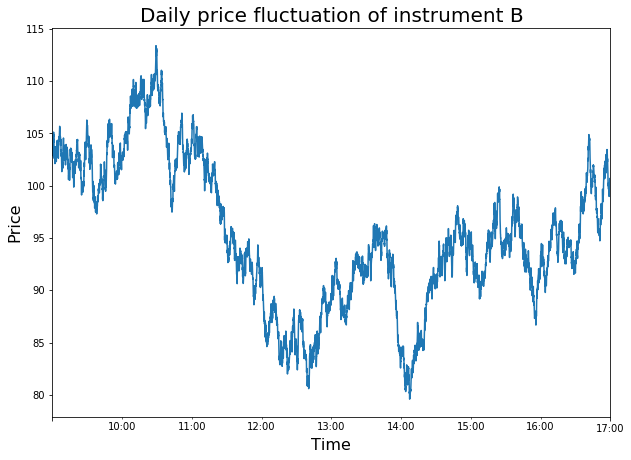

In [150]:
# We do the same for the price of instrument B
fig2 = plt.figure()
fig2.subplots_adjust(top=0.8)

plt.ylabel('Price', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Daily price fluctuation of instrument B', fontsize=20)
instrument_B_resampled['Price'].plot(figsize=(10, 8))
plt.show()

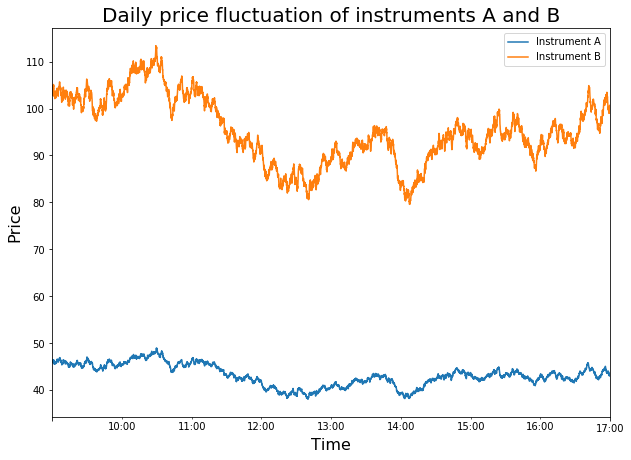

In [152]:
# We immediately notice that the two stocks follow extremely similar behaviours throughout the day
# Another useful plot contains the price of both instrument A and instrument B together
# In this way we can obtain a more immediate comparison between the two stocks

fig3 = plt.figure()
fig3.subplots_adjust(top=0.8)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Time of the day', fontsize=16)
plt.title('Daily price fluctuation of instruments A and B', fontsize=20)
instrument_A_resampled['Price'].plot(figsize=(10, 8), label='Instrument A')
instrument_B_resampled['Price'].plot(figsize=(10, 8), label='Instrument B')
plt.legend(loc="upper right")
plt.show()

### 2 - Analyses

#### Correlation

Because of our findings after we plotted the data, we move on to studying the correlation between these two stocks. We expect to find that in this case the two stocks are highly correlated.

In [7]:
# To calculate correlation we can use the built-in pandas function corr()
# We choose this function since we are simply interested in linear correlation between the two prices
# We begin by extracting the price data from the dataframes

price_A = instrument_A_resampled['Price']
price_B = instrument_B_resampled['Price']

In [8]:
# After which we proceed to calculate linear correlation betwwen the two datasets
price_A.corr(price_B)

# We notice that the two stock prices display a strong positive correlation between them, as we expected from the visualisation of the data
# This implies that the prices of the two stocks display similar behaviours over time
# This presents a valuable trading opportunity. By following the movement of one stock (e.g. stock A), one can predict the direction of the price of the other stock (e.g. stock B).
# This would present an opportunity especially if the price of one of the two stocks (say stock A) responds earlier to a certain event(e.g. global news), leading to a time lag between the responses in prices between the two stocks
# This would allow one to design a profitable trading strategy by following the movements of stock A and trading stock B based on how the price of stock A fluctuates
# Knowing that the two stocks are strongly correlated provides, in fact, a competitive advantage in predicting the evolution of stock B's price over time
# To really strengthen our understanding of a possible trading strategy, we will also proceed to study cointegration.

0.9780113380935134

In [9]:
# For completeness, we can also verify this result using numpy, as follows
price_A_array = price_A.values
price_B_array = price_B.values
np.corrcoef(price_A_array, price_B_array)
# Which, as expected, perfectly confirms the result obtained with the previous method

array([[1.        , 0.97801134],
       [0.97801134, 1.        ]])

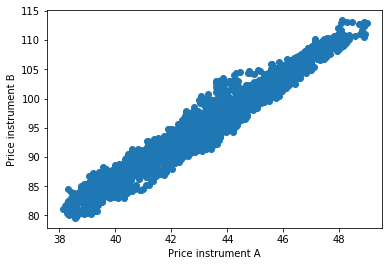

In [10]:
# To help us better visualise the correlation between the two stock prices, we can construct a scatter plot, with the price of instrument A on the x-axis, and the price of instrument B on the y-axis

plt.scatter(price_A, price_B)
plt.xlabel('Price instrument A')
plt.ylabel('Price instrument B')
plt.show()

# This plot clearly shows that there is a strong positive correlation between the prices of the two stocks, exactly as we previously found using numerical methods.

#### Cointegration

Now that we have assessed that the two stock prices display a strong positive correlation with each other, we can proceed to test cointegration. To do so, we begin by attempting to fit a linear model between the two stock prices. We perform the linear regression via ordinary least squares method.

For context, cointegration is an extremely important property of a pair of stocks (and time-series in general). Essentially, two time series are said to be cointegrated if one can construct a combination of the two which behaves as a stationary time series. A stationary time series is one that displays the typical behaviour of statistical noise, such that the values oscillate randomly around a stable mean. This will become clearer later, through visualisation.

In [11]:
# We can perform ordinary least squares regression using numpy
A = np.vstack([price_A_array, np.ones(len(price_A_array))]).T
m, c = np.linalg.lstsq(A, price_B_array, rcond=None)[0]
m, c
# Where m is the slope of the best-fit line, and c is the y-intercept

(2.9703608185213217, -33.05133646651482)

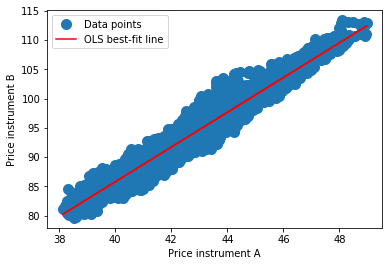

In [74]:
# We can then proceed to visualise the results
# We plot the two prices in a scatterplot as before, and include the best-fit line that we obtained through OLS

sct_plot = plt.plot(price_A_array, price_B_array, 'o', label='Data points', markersize=10)
sct_plot = plt.plot(price_A_array, m*price_A_array + c, 'r', label='OLS best-fit line')
plt.xlabel('Price instrument A')
plt.ylabel('Price instrument B')
sct_plot = plt.legend()
plt.show()

At this point, we can check whether we can construct a stationary time series using these two stocks. To do so, we create a new time series that contains both stock A and stock B. The two stocks are combined in such a way that the overall value should be stationary around a certain mean. If we can do so, this would imply that indeed the two instruments are cointegrated and that we can use them to construct a stationary time series. Since via the OLS method, we obtained that (to good approximation) Price B = m(Price A) + c, we can expect that the combination Price B - m(Price A) should display a stationary behaviour with mean c.  We can verify this hypothesis by explicitly constructing this new time series into a dataframe.

In [12]:
stationary_time_series = pd.DataFrame()
stationary_time_series['Value'] = instrument_B_resampled.Price - m*instrument_A_resampled.Price  

At this point we proceed to explicitly verify cointegration between the two stocks. We can do this relying on the augmented Dickey-Fuller test. It tests the null-hypothesis that the time series contains the unit root. If we can reject the null hypothesis with a high confidence level, then we are able to claim that there is no unit root in the time series and thus the time series is stationary. To do so, we rely on the statsmodels package of Python, which conveniently contains a function implementing the augmented Dickey-Fuller test.



In [13]:
import statsmodels.tsa.stattools as ts
# We let the algorithm compute the optimal number of maximal lags iteratively, by specifying the argument autolag='AIC'
adf = ts.adfuller(stationary_time_series['Value'], autolag='AIC')

print("The ADF statistic is: " + str(adf[0]))
print("The critical thresholds for different confidence levels are: ")
print(adf[4])
print("The p-value is: " + str(adf[1]))      

The ADF statistic is: -4.513485663925446
The critical thresholds for different confidence levels are: 
{'1%': -3.4314913522137753, '5%': -2.8620443684366386, '10%': -2.5670384734919445}
The p-value is: 0.00018589639616242628


We can see that at the 99% confidence level, we can reject the null-hypothesis, and thus we claim that the time series is stationary, thus confirming our hypothesis of cointegration between the two stocks. For convenience, we plot the result and notice that it appears to display the typical behaviour of a stationary time series reverting to the mean, as expected. In particular, it displays a sinusoidal shape oscillating around the expected mean of approximately -33.

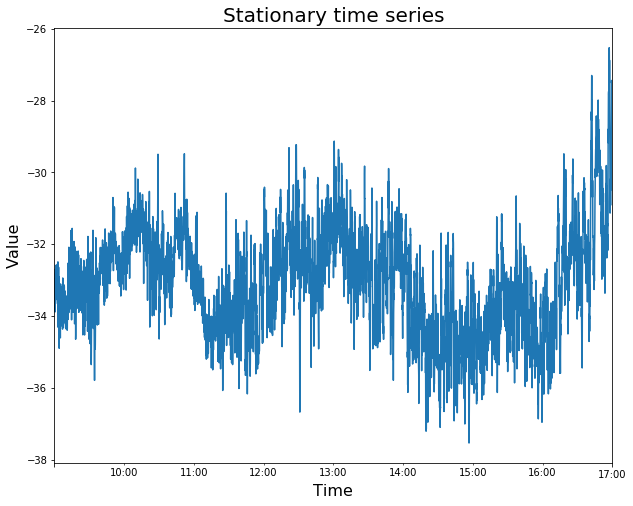

In [15]:
stationary_time_series['Value'].plot(figsize=(10, 8))
plt.ylabel('Value', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Stationary time series', fontsize=20)
plt.show()

### 3 - Trading model

Here you will use the above findings to create a simple (pair) trading model.

#### Theoretical price (fair price)

We begin by calculating a theoretical price for B based on the price of A (or vice versa), using the previous results. We then compare visually the theoretical price of B to the actual price of B in a plot. 

In [16]:
# We use our previous findings to calculate a theoretical price for instrument B, based on the price of instrument A
# We expect that the theoretical price of instrument B will perfectly follow the linear relation on the price of instrument A that we previously computed
instrument_A_resampled_times = instrument_A_resampled.index
# Add a new column to the dataframe of instrument B that will contain the theoretical price
instrument_B_resampled['Theoretical price'] = 0.0
for time in instrument_A_resampled_times:
    # We insert each theoretical price to be the one predicted by the linear relation based on the price of instrument A
    time_index_instrument_B_resampled = instrument_B_resampled.index.get_loc(time)
    instrument_B_resampled['Theoretical price'][time_index_instrument_B_resampled] = m*instrument_A_resampled['Price'][time] + c

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [163]:
# Inspect the modifications made to the instrument B dataframe
# Notice the new column containing the theoretical price
instrument_B_resampled

,Hour,Minute,Second,Millisecond,Time,Price,Theoretical price
Time,,,,,,,
2022-09-05 09:00:05,9,0,4,819,2022-09-05 09:00:04.819,104.019,104.001112
2022-09-05 09:00:10,9,0,9,891,2022-09-05 09:00:09.891,103.474,103.763483
2022-09-05 09:00:15,9,0,14,830,2022-09-05 09:00:14.830,103.289,103.525854
2022-09-05 09:00:20,9,0,19,759,2022-09-05 09:00:19.759,103.900,103.822890
2022-09-05 09:00:25,9,0,24,624,2022-09-05 09:00:24.624,102.885,103.288225
...,...,...,...,...,...,...,...
2022-09-05 16:59:40,16,59,39,913,2022-09-05 16:59:39.913,99.678,95.951434
2022-09-05 16:59:45,16,59,44,643,2022-09-05 16:59:44.643,99.338,96.070248
2022-09-05 16:59:50,16,59,49,974,2022-09-05 16:59:49.974,99.658,96.189063


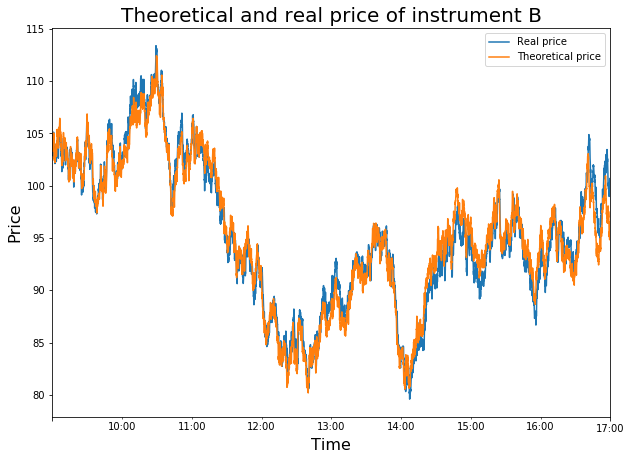

In [54]:
# At this point, we compare the theoretical price of instrument B to its actual price, as a function of time
# We do so by means of a plot depicting both quantities
fig3 = plt.figure()
fig3.subplots_adjust(top=0.8)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Theoretical and real price of instrument B', fontsize=20)
instrument_B_resampled['Price'].plot(figsize=(10, 8), label='Real price')
instrument_B_resampled['Theoretical price'].plot(figsize=(10, 8), label='Theoretical price')
plt.legend(loc="upper right")
plt.show()


We notice that indeed there is a very good agreement between the two, and that the theoretical price follows the behaviour of the actual price very closely. We can also see that there are periods of the day where the two quantities diverge, and these represent valuable trading opportunities, since we can compare the actual price of the stock to its theoretical one, and use that information to predict whether the actual value of the stock will rise or fall.

#### Pair trading

As previously explained, we can certainly construct a pair trading model using the information we extracted. We create signals in the dataframe that indicate when the theoretical price of instrument B is greater than its actual price. When this happens, we want to buy stock B, as we expect that the actual price will rise and adjust with its theoretical price. Clearly when the theoretical price of B is lower than its actual price, we proceed to sell the stock, as we expect that the actual price will drop.

In [17]:
# We begin by creating a new column called Signal in the instrument_B dataframe
# We do this by relying on np.where to set the signal to 1 when the theoretical price is higher than the actual price, and zero otherwise
instrument_B_resampled['Signal'] = np.where(instrument_B_resampled['Theoretical price'] > instrument_B_resampled['Price'], 1.0, 0.0)

# At this point, we proceed to generate trading orders. 1.0 corresponds to a buy position, -1.0 corresponds to a sell position
instrument_B_resampled['Positions'] = instrument_B_resampled['Signal'].diff()
instrument_B_resampled.iloc[0,8] = instrument_B_resampled.iloc[0,7] # We also make sure to set the first position to be equal to the signal, since we cannot take the difference with respect to any previous entry, as we can do for the others
# Finally, we inspect the data to verify that our procedure ran successfully
instrument_B_resampled

,Hour,Minute,Second,Millisecond,Time,Price,Theoretical price,Signal,Positions
Time,,,,,,,,,
2022-09-07 09:00:05,9,0,4,819,2022-09-07 09:00:04.819,104.019,104.001112,0.0,0.0
2022-09-07 09:00:10,9,0,9,891,2022-09-07 09:00:09.891,103.474,103.763483,1.0,1.0
2022-09-07 09:00:15,9,0,14,830,2022-09-07 09:00:14.830,103.289,103.525854,1.0,0.0
2022-09-07 09:00:20,9,0,19,759,2022-09-07 09:00:19.759,103.900,103.822890,0.0,-1.0
2022-09-07 09:00:25,9,0,24,624,2022-09-07 09:00:24.624,102.885,103.288225,1.0,1.0
...,...,...,...,...,...,...,...,...,...
2022-09-07 16:59:40,16,59,39,913,2022-09-07 16:59:39.913,99.678,95.951434,0.0,0.0
2022-09-07 16:59:45,16,59,44,643,2022-09-07 16:59:44.643,99.338,96.070248,0.0,0.0
2022-09-07 16:59:50,16,59,49,974,2022-09-07 16:59:49.974,99.658,96.189063,0.0,0.0


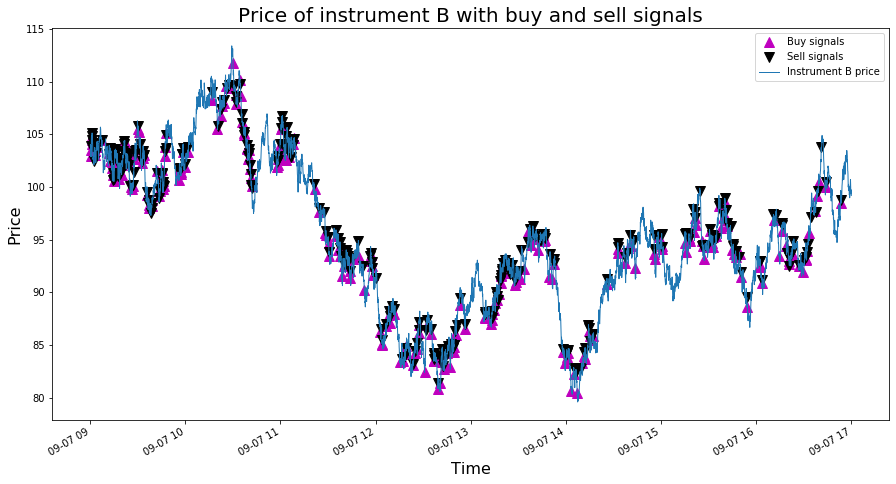

In [19]:
# At this point, we proceed to visualise the data
# We create a plot of the price of stock B which includes points in time when we should buy stock B following this strategy, and points in time when we should sell stock B
# The points in time when we should buy stock B are represented by purple triangles pointing up
# The points in time when we should sell stock B are represented by black triangles pointing down


fig = plt.figure()
# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.title('Price of instrument B with buy and sell signals', fontsize=20)


# Plot the buy signals as upwards purple triangles
ax1.plot(instrument_B_resampled.loc[instrument_B_resampled.Positions == 1.0].index, 
         instrument_B_resampled.Price[instrument_B_resampled.Positions == 1.0],
         '^', markersize=10, color='m', label='Buy signals')

# Plot the sell signals as downwards black triangles
ax1.plot(instrument_B_resampled.loc[instrument_B_resampled.Positions == -1.0].index, 
         instrument_B_resampled.Price[instrument_B_resampled.Positions == -1.0],
         'v', markersize=10, color='k', label='Sell signals')


# Plot the actual price of stock B
instrument_B_resampled['Price'].plot(figsize=(15, 8), ax=ax1, lw=1., label='Instrument B price')
plt.legend(loc="upper right")

plt.show()

We notice, that based on first inspection, the strategy seems to be valid, as in most cases the black triangles are above the purple ones, indicating that we would normally sell at a higher price than we bought the stock for. We can also see that this is not always the case, so there is margin for improvement in this strategy.

Finally, we proceed to evaluate whether this trading strategy could be effectively profitable or not. To do so, we assume to possess a starting portfolio with 1000 dollars cash (assuming the price of stock B is listed in dollars). Every time there is a buy signal generated, we buy as many units of stock B as our portfolio allows. Every time there is a sell signal generated, we sell all the units of stock B that we have in our portfolio.

In [90]:
# Finally, we proceed to evaluate whether this trading strategy could be profitable or not
# To do, we assume to possess a starting portfolio with 1000$ cash (assuming the price of stock B is listed in $)
# Every time there is a buy signal generated, we buy as many units of stock B as our portfolio allows
# Every time there is a sell signal generated, we sell all the units of stock B that we have in our portfolio

import math

portfolio_size_cash = 1000.0
number_of_stocks_in_portfolio = 0

for index in range(len(instrument_B_resampled['Positions'].values)):
    if instrument_B_resampled.iloc[index][8] == 0.0:
        continue  
    if instrument_B_resampled.iloc[index][8] == 1.0:
        n_stocks = math.floor(portfolio_size_cash/instrument_B_resampled.iloc[index][5])
    else:
        n_stocks = number_of_stocks_in_portfolio
    portfolio_size_cash -= n_stocks*(instrument_B_resampled.iloc[index][8]*instrument_B_resampled.iloc[index][5])
    number_of_stocks_in_portfolio += instrument_B_resampled.iloc[index][8]*n_stocks
    
print("The profit made via this trading strategy is: {0} $".format(round((portfolio_size_cash - 1000.0 + number_of_stocks_in_portfolio*instrument_B_resampled.iloc[index][-1]), 3)))

# We find that this trading strategy can be very profitable, since in the span of one day we made a profit of approximately 3570.443 $ starting with only 1000 $

The profit made via this trading strategy is: 3570.443 $


#### Final Thoughts

The trrading strategy turns out to be extremely profitable in the context of this analysis. Of course, several aspects of real-world trading have been ignored.

One aspect that should certainly be taken into consideration when applying such a model to stock trading in the real world would be transaction fees. The model I have constructed so far assumes that no transaction costs are present when placing a trade. Transaction costs would certainly heavily reduce the profit generated via this trading strategy, since this strategy is based on a large number of transactions during the course of one day. To account for this aspect of real-world trading, it could be a good idea to only perform trades when the theoretical price differs from the real one by a certain percentage. For instance, a possibility would be to only buy stock B when the theoretical price is higher than the real price by 5% or more. Similarly, one would only sell stock B when the theoretical price is less than 95% of the real price of the stock. This would significantly reduce the number of trades performed during the course of one day, and one would hope that the trades performed would be particularly profitable ones. Moreover, one could design a strategy where the number of units of stock B purchased or sold depends on the difference between the theoretical and the actual price of stock B. For instance, if the difference is extremely high, then one would trade as many units of stock B as allowed by their portfolio. If the difference is not so sharp, then one would trade a lower number of units. This approach would also limit the number of units of stock B traded during the day, and it would reduce the transaction fees. In addition, having identified two highly correlated stock, one could implement a hedging strategy. When the two stocks diverge from each other, one opens a long position on the underperforming one, and at the same time opens a short position on the outperforming one. This combined trade strongly limits the possibility of losses by the trader. 
Another important aspect to consider when applying this kind of models to the real world is that it is extremely hard to find stocks that display such a strong correlation with each other. Most likely, it would be extremely hard to find stocks with such a high level of correlation in the real world, and this would clearly limit the efficacy of a pairs trading strategy.

I believe this strategy would work well in both the stock and commodity markets, once the trader is able to indenitfy instruments that are strongly correlated with each other. In the commodity market, for instance, one could consider two minerals which are key components used in the manifacturing process of the same product (e.g. batteries, transistors, etc.). Having identified such minerals, one would expect to see a strong correlation between the prices of these two instruments, and use that to develop a pairs trading model. One would expect this strategy to work because if these two minerals have been used for many years as key components in a certain manifacturing process, they will continue to do so and be (strongly) correlated to each other in the future (unless some scientific discovery allows one of the two to be replaced by a different element). In the stock market, this form of pairs trading has been tested over many years, and it has proven to be a profitable strategy. The key to the success of this strategy is to find two stocks that are highly correlated to each other and for which there are valid reasons to believe that they will stay correlated over a long period of time.

On the contrary, I would expect this type of strategy to perform poorly in markets where the price of an instrument is not necessarily connected to any real-world entity, and where correlation between instruments can fluctuate significantly and be easily disrupted. For instance, I would expect that such a strategy would perform poorly in the cryptocurrency market, where correlations between different currencies can be the result of temporary factors or even random fluctuations. This would pose a serious risk to the success of such a strategy, since the correlation between two instruments could be easily lost. This is because in this case there is no practical reason why the two currencies should stricly remain correlated in the future. I believe that this lack of meaningful reasons why the correlation between two instruments should be maintained over time would pose a threat to the success of such a trading strategy.